In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('default')

In [2]:
# importing data

schools = pd.read_csv(".\education_analytics\Masterlist of Schools.csv", index_col="school.id")

school_locs = pd.read_csv(".\education_analytics\Schools Location Data.csv", 
                          encoding = "latin-1", 
                          index_col="School ID",
                          usecols=["School ID", "Enrolment", "Latitude", "Longitude"])

rooms = pd.read_csv('.\education_analytics\Rooms data.csv', index_col="School ID")

teachers = pd.read_csv(".\education_analytics\Teachers data.csv", index_col="school.id")

mooe = (pd.read_csv('.\education_analytics\MOOE data.csv', index_col="school.id", usecols=["school.id", " school.mooe "])
             .replace(",", "", regex=True).astype(float))

boncodin = pd.read_csv("schools_boncodin.csv", 
                          index_col="school.id",
                          usecols=["school.id", "boncodin_mooe"])

In [3]:
schools_master = pd.concat([schools, school_locs, rooms, teachers, mooe, boncodin], axis=1)
schools_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46751 entries, 100001 to 900279
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   school.name                 46603 non-null  object 
 1   school.region               46603 non-null  object 
 2   school.region.name          46603 non-null  object 
 3   school.province             46603 non-null  object 
 4   school.cityhall             46602 non-null  object 
 5   school.division             46603 non-null  object 
 6   school.citymuni             46603 non-null  object 
 7   school.district             46603 non-null  object 
 8   school.legdistrict          46603 non-null  object 
 9   school.type                 46603 non-null  object 
 10  school.abbrev               18167 non-null  object 
 11  school.previousname         42221 non-null  object 
 12  school.mother.id            46596 non-null  float64
 13  school.address           

In [4]:
#importing shapefile
shapefile = gpd.read_file('./Regions/Regions.shp')
shapefile.head()


,REGION,geometry
0,Autonomous Region of Muslim Mindanao (ARMM),"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."
1,Bicol Region (Region V),"MULTIPOLYGON (((122.98417 11.71056, 122.98333 ..."
2,CALABARZON (Region IV-A),"MULTIPOLYGON (((125.22166 10.43444, 125.22195 ..."
3,Cagayan Valley (Region II),"MULTIPOLYGON (((122.47040 16.91995, 122.47040 ..."
4,Caraga (Region XIII),"MULTIPOLYGON (((126.41750 7.96417, 126.41778 7..."


In [5]:
#replace roman numerals in region names
schools_master.replace({'school.region' : {'Autonomous Region of Muslim Mindanao (ARMM)': 'ARMM', 
                                           'Region V' : 'Region 05', 
                                           'Region IV-A' : 'Region 04A', 
                                           'Region II' : 'Region 02', 
                                           'Region XIII' : 'CARAGA', 
                                           'Region III' : 'Region 03', 
                                           'Region VII' : 'Region 07', 
                                           'Cordillera Administrative Region (CAR)' : 'CAR', 
                                           'Region XI' : 'Region 11', 
                                           'Region VIII' : 'Region 08', 
                                           'Region I' : 'Region 01', 
                                           'Region IV-B' : 'Region 04B', 
                                           'Metropolitan Manila' : 'NCR', 
                                           'Region X' : 'Region 10', 
                                           'Region XII' : 'Region 12', 
                                           'Region VI' : 'Region 06', 
                                           'Region IX' : 'Region 09'}}, inplace=True)
schools_master['school.region'].unique()

array(['Region 01', 'Region 02', nan, 'Region 03', 'Region 04A',
       'Region 04B', 'Region 05', 'Region 06', 'Region 07', 'Region 08',
       'Region 09', 'Region 10', 'Region 11', 'Region 12', 'CARAGA',
       'ARMM', 'CAR', 'NCR'], dtype=object)

In [6]:
#ordinal encoding for urbanization level
schools_master['school.urban'].fillna("missing", inplace=True)
cat = pd.Categorical(schools_master['school.urban'], categories=["missing", "Rural", "Partially Urban", "Urban"], ordered=True)
labels, unique = pd.factorize(cat, sort=True) 
schools_master['school.urban'] = labels

In [7]:
#replace city income values
city_income_corrections={
    "P 25 M or more but less than P 35 M":30000000,
    "P 35 M or more but less than P 45 M":40000000,
    "P 15 M or more but less than P 25 M":20000000,
    "P 45 M or more but less than P 55 M":50000000,
    "P 160 M or more but less than P 240 M":200000000,
    "P 240 M or more but less than P 320 M":280000000,
    "P 55 M or more":55000000,
    "P 320 M or more but less than P 400 M":360000000,
    "P 400 M or more":400000000,
    "Below P 15 M":15000000,
    "P 80 M or more but less than P 160 M":120000000
}

incorrect_city_income_format = list(city_income_corrections.keys())

def assign_city_income(x):
  if x["school.cityincome"] in incorrect_city_income_format:
    corrected_city_income=city_income_corrections[x["school.cityincome"]]
    x["school.cityincome"]=corrected_city_income

  return x

schools_master = schools_master.apply(lambda x: assign_city_income(x), axis=1)

schools_master.dropna()
schools_master = schools_master[schools_master["school.cityincome"] != "Special Class"]

#schools_master

In [8]:
#isolate numerical data
schools_num = schools_master[['school.region', 'school.province','school.urban', 'school.cityincome', 'school.classification', 'rooms.standard.academic', 'rooms.standard.unused',
       'rooms.nonstandard.academic', 'rooms.nonstandard.unused',
       'teachers.instructor', 'teachers.mobile', 'teachers.regular',
       'teachers.sped','Enrolment', ' school.mooe ', 'boncodin_mooe']].reset_index()

schools_num["rooms_total"] = (schools_num['rooms.standard.academic'] + 
                             schools_num['rooms.standard.unused'] + 
                             schools_num['rooms.nonstandard.academic'] + 
                             schools_num['rooms.nonstandard.unused'])

schools_num["teachers_total"] = (schools_num['teachers.instructor'] + 
                             schools_num['teachers.mobile'] + 
                             schools_num['teachers.regular'] + 
                             schools_num['teachers.sped'])

schools_num["st_ratio"] = schools_num["Enrolment"] / schools_num["teachers_total"]
schools_num["rt_ratio"] = schools_num["Enrolment"] / schools_num["rooms_total"]

schools_num['mooe_diff'] = schools_num[' school.mooe '] - schools_num['boncodin_mooe']
schools_num['percent_diff'] = schools_num['mooe_diff'] / schools_num[' school.mooe ']

schools_num

,index,school.region,school.province,school.urban,school.cityincome,school.classification,rooms.standard.academic,rooms.standard.unused,rooms.nonstandard.academic,rooms.nonstandard.unused,teachers.instructor,teachers.mobile,teachers.regular,teachers.sped,Enrolment,school.mooe,boncodin_mooe,rooms_total,teachers_total,st_ratio,rt_ratio,mooe_diff,percent_diff
0,100001,Region 01,ILOCOS NORTE,2,40000000,Elementary,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,90.0,84000.0,72000.0,2.0,2.0,45.000000,45.000000,12000.0,0.142857
1,100002,Region 01,ILOCOS NORTE,2,40000000,Elementary,12.0,0.0,0.0,0.0,0.0,6.0,11.0,0.0,456.0,268000.0,235200.0,12.0,17.0,26.823529,38.000000,32800.0,0.122388
2,100003,Region 01,ILOCOS NORTE,2,40000000,Elementary,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,167.0,135000.0,119400.0,6.0,7.0,23.857143,27.833333,15600.0,0.115556
3,100004,Region 01,ILOCOS NORTE,2,40000000,Elementary,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,122.0,116000.0,110400.0,6.0,7.0,17.428571,20.333333,5600.0,0.048276
4,100005,Region 01,ILOCOS NORTE,2,40000000,Elementary,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,77.0,115000.0,101400.0,6.0,7.0,11.000000,12.833333,13600.0,0.118261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46601,326101,Region 12,SULTAN KUDARAT,2,200000000,Secondary,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,262.0,174000.0,NaN,2.0,NaN,NaN,131.000000,NaN,NaN
46602,326102,Region 12,SULTAN KUDARAT,2,200000000,Secondary,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,191.0,144000.0,NaN,2.0,NaN,NaN,95.500000,NaN,NaN
46603,326501,ARMM,MAGUINDANAO,2,20000000,Secondary,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,185.0,NaN,NaN,NaN,0.0,inf,NaN,NaN,NaN
46604,356059,Region 07,CEBU,2,NaN,Secondary,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,136.0,177000.0,NaN,3.0,NaN,NaN,45.333333,NaN,NaN


In [9]:
schools_num.isna().sum()

index                            0
school.region                  148
school.province                148
school.urban                     0
school.cityincome             1124
school.classification          148
rooms.standard.academic        339
rooms.standard.unused          339
rooms.nonstandard.academic     343
rooms.nonstandard.unused       343
teachers.instructor           1710
teachers.mobile               1710
teachers.regular              1710
teachers.sped                 1710
Enrolment                      127
 school.mooe                  2723
boncodin_mooe                 4408
rooms_total                    343
teachers_total                1710
st_ratio                      1798
rt_ratio                       469
mooe_diff                     4408
percent_diff                  4408
dtype: int64

In [10]:
#data cleaning and pre-processing
schools_num_clean = schools_num.dropna()
# Get indexes where name column doesn't have value 
indexNames = schools_num_clean[((schools_num_clean['school.cityincome'] == 'Special Class') | 
                                (schools_num_clean["teachers_total"] == 0) |
                                (schools_num_clean["rooms_total"] == 0))].index 
# Delete these row indexes from dataFrame
schools_num_clean.drop(indexNames, inplace=True)

print(schools_num_clean.isna().sum())
schools_num_clean.info()

index                         0
school.region                 0
school.province               0
school.urban                  0
school.cityincome             0
school.classification         0
rooms.standard.academic       0
rooms.standard.unused         0
rooms.nonstandard.academic    0
rooms.nonstandard.unused      0
teachers.instructor           0
teachers.mobile               0
teachers.regular              0
teachers.sped                 0
Enrolment                     0
 school.mooe                  0
boncodin_mooe                 0
rooms_total                   0
teachers_total                0
st_ratio                      0
rt_ratio                      0
mooe_diff                     0
percent_diff                  0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40829 entries, 0 to 46506
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
#provinical dataframe

prov = schools_num_clean.groupby(["school.province"])[["mooe_diff", "school.cityincome", "school.urban", "Enrolment", "rooms_total", "teachers_total", "st_ratio", "rt_ratio"]].agg(
    MOOE_Diff=('mooe_diff',sum),
    Schools_Income=("school.cityincome", sum), 
    Urbanization=("school.urban", np.mean),
    Schools_Enrollment=("Enrolment", sum),
    Schools_Rooms=("rooms_total", sum),
    Schools_Teachers=("teachers_total", sum),
    Student_Teacher_Ratio=("st_ratio", np.mean),
    Room_Utilization=("rt_ratio", np.mean))

prov

,MOOE_Diff,Schools_Income,Urbanization,Schools_Enrollment,Schools_Rooms,Schools_Teachers,Student_Teacher_Ratio,Room_Utilization
school.province,,,,,,,,
ABRA,4169800.0,7595000000,1.831715,48120.0,1663.0,1901.0,24.292022,26.416669
AGUSAN DEL NORTE,11770200.0,58460000000,2.000000,144814.0,2772.0,3826.0,44.523091,47.967150
AGUSAN DEL SUR,15079400.0,41120000000,2.000000,176156.0,3484.0,4301.0,47.345127,49.758840
AKLAN,12621200.0,13235000000,2.057292,117229.0,3083.0,3742.0,33.186524,36.433974
ALBAY,24209800.0,67445000000,2.046676,327263.0,7700.0,9035.0,36.720264,39.206970
ANTIQUE,13057800.0,19840000000,2.000000,135833.0,3504.0,4371.0,32.684328,37.856558
APAYAO,2699800.0,7930000000,1.709497,25917.0,814.0,898.0,33.509232,33.411888
AURORA,5421400.0,7100000000,1.896341,50344.0,1306.0,1458.0,35.541896,35.968387
BATAAN,13292400.0,13480000000,2.000000,150114.0,3356.0,3801.0,40.980476,42.083580


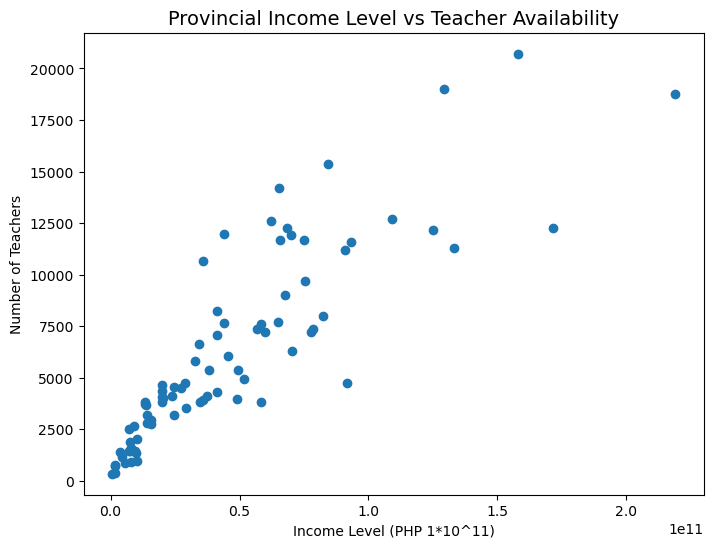

In [12]:
#scatterplot for Provincial Income Level vs Teacher Availability

plt.figure(figsize=(8,6))
plt.scatter(prov["Schools_Income"], prov["Schools_Teachers"])
plt.title("Provincial Income Level vs Teacher Availability", fontsize=14)
plt.ylabel("Number of Teachers")
plt.xlabel("Income Level (PHP 1*10^11)")
plt.show()
#df_final["ratio"] = df_final["total_teachers"]/df_final["school.cityincome"]

#df_final.plot.bar(stacked=True)

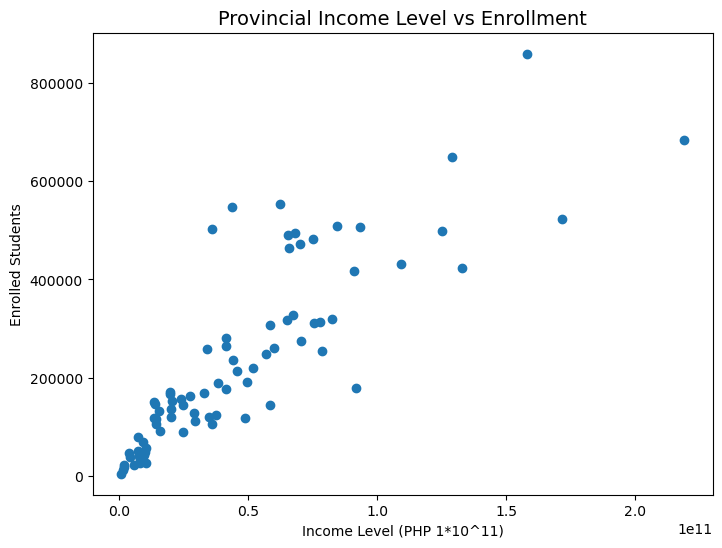

In [13]:
#scatterplot for Provincial Income Level vs Enrollment

plt.figure(figsize=(8,6))
plt.scatter(prov["Schools_Income"], prov["Schools_Enrollment"])
plt.title("Provincial Income Level vs Enrollment", fontsize=14)
plt.ylabel("Enrolled Students")
plt.xlabel("Income Level (PHP 1*10^11)")
plt.show()

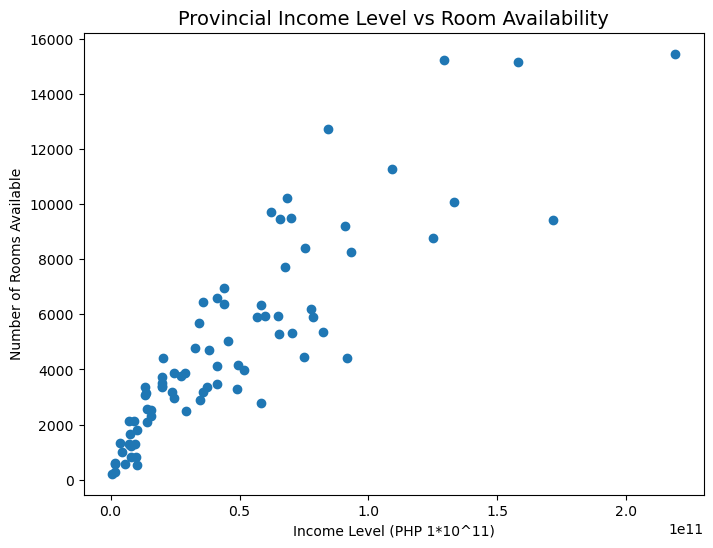

In [14]:
#scatterplot for Provincial Income Level vs Room Availability

plt.figure(figsize=(8,6))
plt.scatter(prov["Schools_Income"], prov["Schools_Rooms"])
plt.title("Provincial Income Level vs Room Availability", fontsize=14)
plt.ylabel("Number of Rooms Available")
plt.xlabel("Income Level (PHP 1*10^11)")
plt.show()

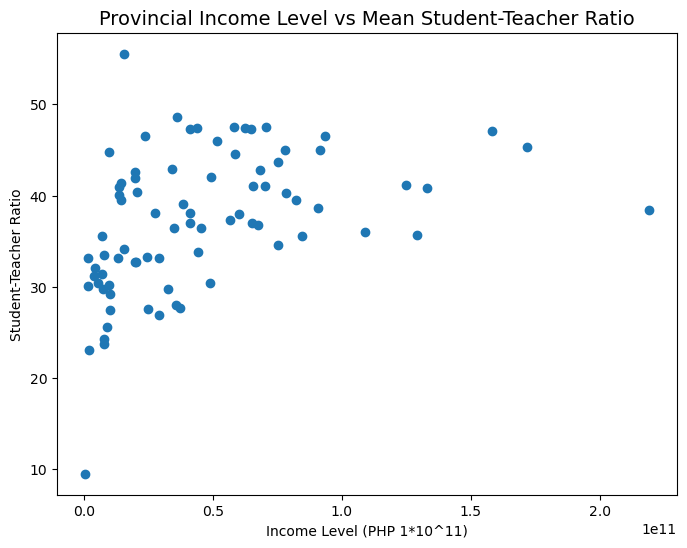

In [15]:
#scatterplot for Provincial Income Level vs Mean Student-Teacher Ratio

plt.figure(figsize=(8,6))
plt.scatter(prov["Schools_Income"], prov["Student_Teacher_Ratio"])
plt.title("Provincial Income Level vs Mean Student-Teacher Ratio", fontsize=14)
plt.ylabel("Student-Teacher Ratio")
plt.xlabel("Income Level (PHP 1*10^11)")
plt.show()

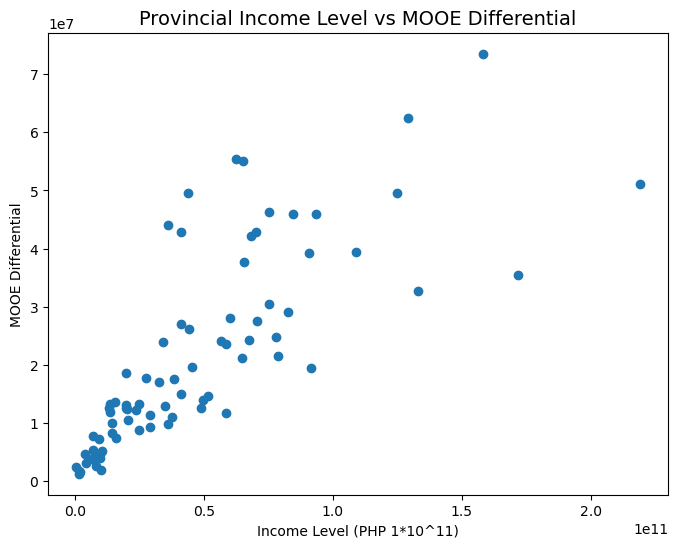

In [16]:
#scatterplot for Provincial Income Level vs MOOE Differential

plt.figure(figsize=(8,6))
plt.scatter(prov["Schools_Income"], prov["MOOE_Diff"])
plt.title("Provincial Income Level vs MOOE Differential", fontsize=14)
plt.ylabel("MOOE Differential")
plt.xlabel("Income Level (PHP 1*10^11)")
plt.show()

In [17]:
prov.corr()

,MOOE_Diff,Schools_Income,Urbanization,Schools_Enrollment,Schools_Rooms,Schools_Teachers,Student_Teacher_Ratio,Room_Utilization
MOOE_Diff,1.000000,0.786335,0.563981,0.973804,0.889738,0.966286,0.493773,0.552911
Schools_Income,0.786335,1.000000,0.225594,0.849350,0.878146,0.864460,0.415507,0.286912
Urbanization,0.563981,0.225594,1.000000,0.472079,0.250456,0.435948,0.382868,0.766738
Schools_Enrollment,0.973804,0.849350,0.472079,1.000000,0.932315,0.984135,0.535365,0.505819
Schools_Rooms,0.889738,0.878146,0.250456,0.932315,1.000000,0.960331,0.414973,0.221598
Schools_Teachers,0.966286,0.864460,0.435948,0.984135,0.960331,1.000000,0.446118,0.433114
Student_Teacher_Ratio,0.493773,0.415507,0.382868,0.535365,0.414973,0.446118,1.000000,0.657197
Room_Utilization,0.552911,0.286912,0.766738,0.505819,0.221598,0.433114,0.657197,1.000000


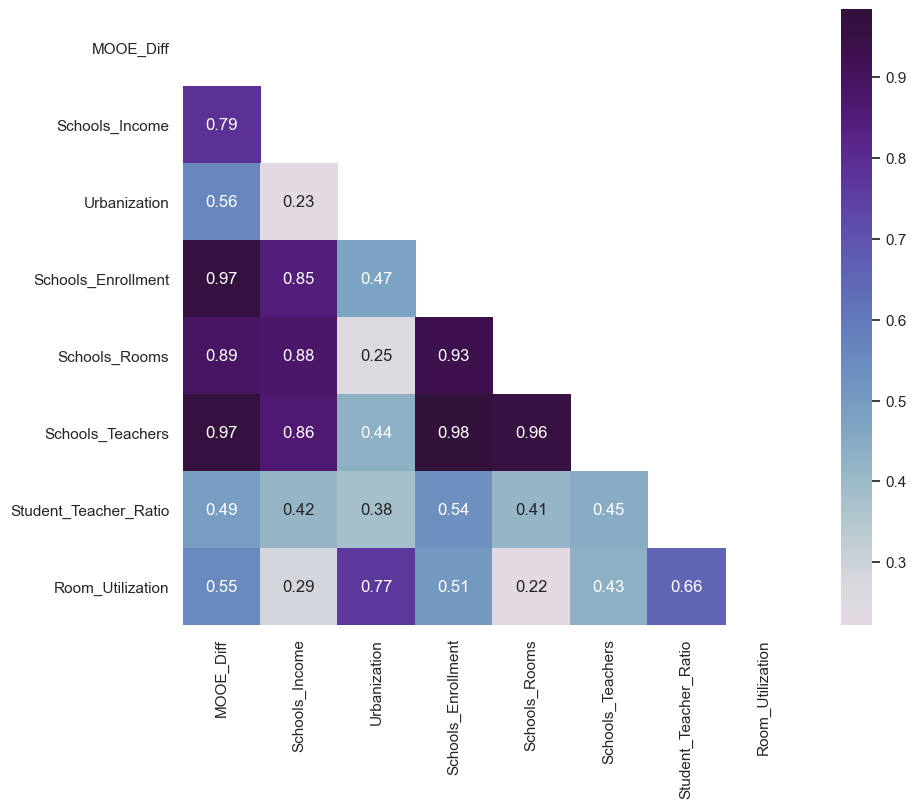

In [18]:
plt.figure(figsize=(10,8))
sns.set_theme(style="white")
mask = np.triu(np.ones_like(prov.corr(), dtype=bool))
#cmap = sns.light_palette("blue", as_cmap=True)
sns.heatmap(prov.corr(), mask=mask, cmap="twilight", center=1, annot=True)

plt.show()

In [19]:
region = schools_num_clean.groupby(["school.region"])[["mooe_diff", "school.cityincome", "school.urban", "Enrolment", "rooms_total", "teachers_total", "st_ratio", "rt_ratio"]].agg(
    MOOE_Diff=('mooe_diff',sum),
    Schools_Income=("school.cityincome", sum), 
    Urbanization=("school.urban", np.mean),
    Schools_Enrollment=("Enrolment", sum),
    Schools_Rooms=("rooms_total", sum),
    Schools_Teachers=("teachers_total", sum),
    Student_Teacher_Ratio=("st_ratio", np.mean),
    Room_Utilization=("rt_ratio", np.mean))

region

,MOOE_Diff,Schools_Income,Urbanization,Schools_Enrollment,Schools_Rooms,Schools_Teachers,Student_Teacher_Ratio,Room_Utilization
school.region,,,,,,,,
CAR,30126600.0,73860000000,1.711465,293982.0,8929.0,10801.0,27.630030,31.244513
CARAGA,50327800.0,165070000000,1.978576,561259.0,11925.0,15813.0,40.294777,45.061074
NCR,144034400.0,181655000000,3.000000,1236876.0,13839.0,32905.0,39.990608,93.807119
Region 01,97015200.0,218610000000,2.071628,1027023.0,26165.0,32231.0,32.503225,36.843873
Region 02,70475800.0,145200000000,1.969106,683670.0,18827.0,21897.0,33.611282,34.028252
Region 03,202060800.0,331300000000,2.141063,2066200.0,42760.0,52657.0,40.507644,44.490928
Region 04A,226992800.0,363645000000,2.293093,2521304.0,39869.0,58067.0,43.576272,58.459276
Region 04B,66410200.0,140300000000,1.938104,716860.0,16515.0,19369.0,40.409553,43.066290
Region 05,129156000.0,237925000000,2.022336,1507911.0,33941.0,40265.0,39.114363,42.876009


In [20]:
# Check region
print('schools df:\n', sorted(schools_num_clean["school.region"].unique()), '\n')
print('shapefile df:\n', sorted(shapefile["REGION"].unique()))

schools df:
 ['CAR', 'CARAGA', 'NCR', 'Region 01', 'Region 02', 'Region 03', 'Region 04A', 'Region 04B', 'Region 05', 'Region 06', 'Region 07', 'Region 08', 'Region 09', 'Region 10', 'Region 11', 'Region 12'] 

shapefile df:
 ['Autonomous Region of Muslim Mindanao (ARMM)', 'Bicol Region (Region V)', 'CALABARZON (Region IV-A)', 'Cagayan Valley (Region II)', 'Caraga (Region XIII)', 'Central Luzon (Region III)', 'Central Visayas (Region VII)', 'Cordillera Administrative Region (CAR)', 'Davao Region (Region XI)', 'Eastern Visayas (Region VIII)', 'Ilocos Region (Region I)', 'MIMAROPA (Region IV-B)', 'Metropolitan Manila', 'Northern Mindanao (Region X)', 'SOCCSKSARGEN (Region XII)', 'Western Visayas (Region VI)', 'Zamboanga Peninsula (Region IX)']


In [21]:
# Replace region name
shapefile.replace({'REGION' : {'Autonomous Region of Muslim Mindanao (ARMM)': 'ARMM', 
                               'Bicol Region (Region V)' : 'Region 05', 
                               'CALABARZON (Region IV-A)' : 'Region 04A', 
                               'Cagayan Valley (Region II)' : 'Region 02', 
                               'Caraga (Region XIII)' : 'CARAGA', 
                               'Central Luzon (Region III)' : 'Region 03', 
                               'Central Visayas (Region VII)' : 'Region 07', 
                               'Cordillera Administrative Region (CAR)' : 'CAR', 
                               'Davao Region (Region XI)' : 'Region 11', 
                               'Eastern Visayas (Region VIII)' : 'Region 08', 
                               'Ilocos Region (Region I)' : 'Region 01', 
                               'MIMAROPA (Region IV-B)' : 'Region 04B', 
                               'Metropolitan Manila' : 'NCR', 
                               'Northern Mindanao (Region X)' : 'Region 10', 
                               'SOCCSKSARGEN (Region XII)' : 'Region 12', 
                               'Western Visayas (Region VI)' : 'Region 06', 
                               'Zamboanga Peninsula (Region IX)' : 'Region 09'}}, inplace=True)
print(sorted(shapefile["REGION"].unique()))

['ARMM', 'CAR', 'CARAGA', 'NCR', 'Region 01', 'Region 02', 'Region 03', 'Region 04A', 'Region 04B', 'Region 05', 'Region 06', 'Region 07', 'Region 08', 'Region 09', 'Region 10', 'Region 11', 'Region 12']


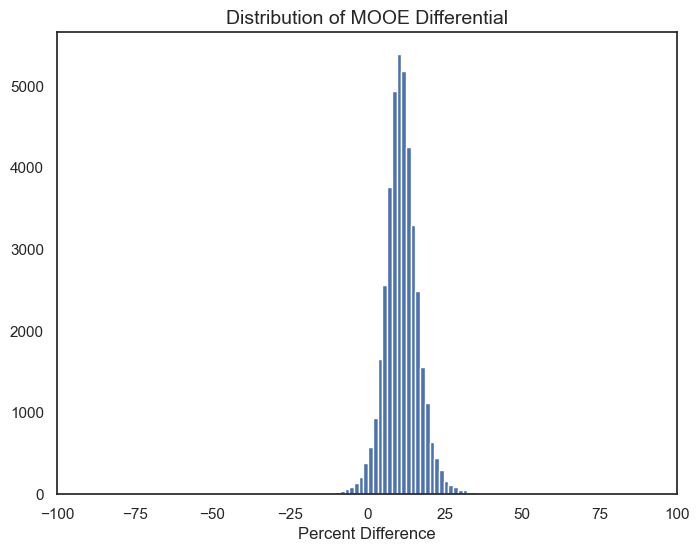

In [22]:
#distribution of percent differences
#plt.set_cmap("Oranges")
plt.figure(figsize=(8,6))
plt.hist(schools_num_clean["percent_diff"]*100, bins=100)
plt.title("Distribution of MOOE Differential", fontsize=14)
plt.xlabel("Percent Difference")
plt.xlim(-100, 100)

plt.show()

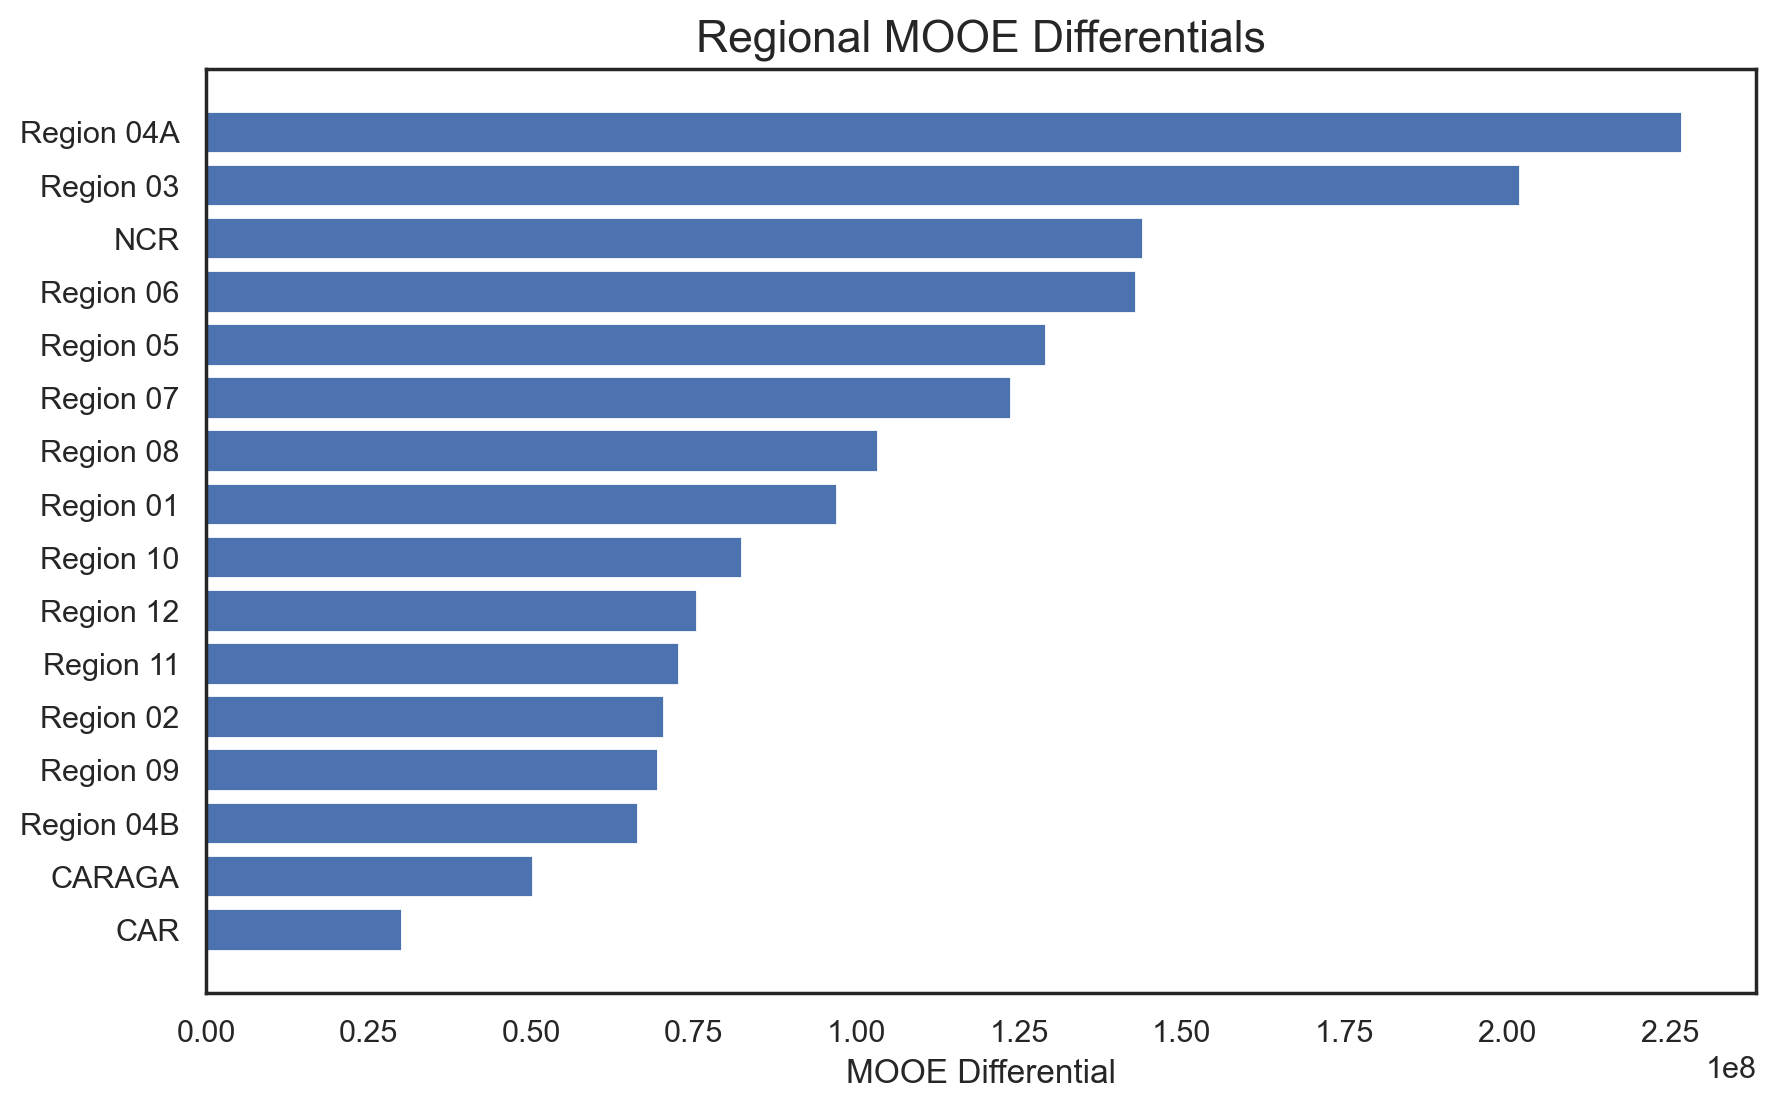

In [23]:
#plot of regional MOOE differential
mpr = region["MOOE_Diff"].sort_values()

# indicates if plotting on the figures or on subplots
plt.figure(figsize=(10,6), dpi=200) 

# the main code to create the graph
plt.barh(mpr.index, mpr.values) 

# additional elements that can be customzed
plt.title("Regional MOOE Differentials", fontsize = 16)
plt.xlabel("MOOE Differential", fontsize=12)
plt.xticks(range(0,250000000,25000000))

# display graph
plt.show()

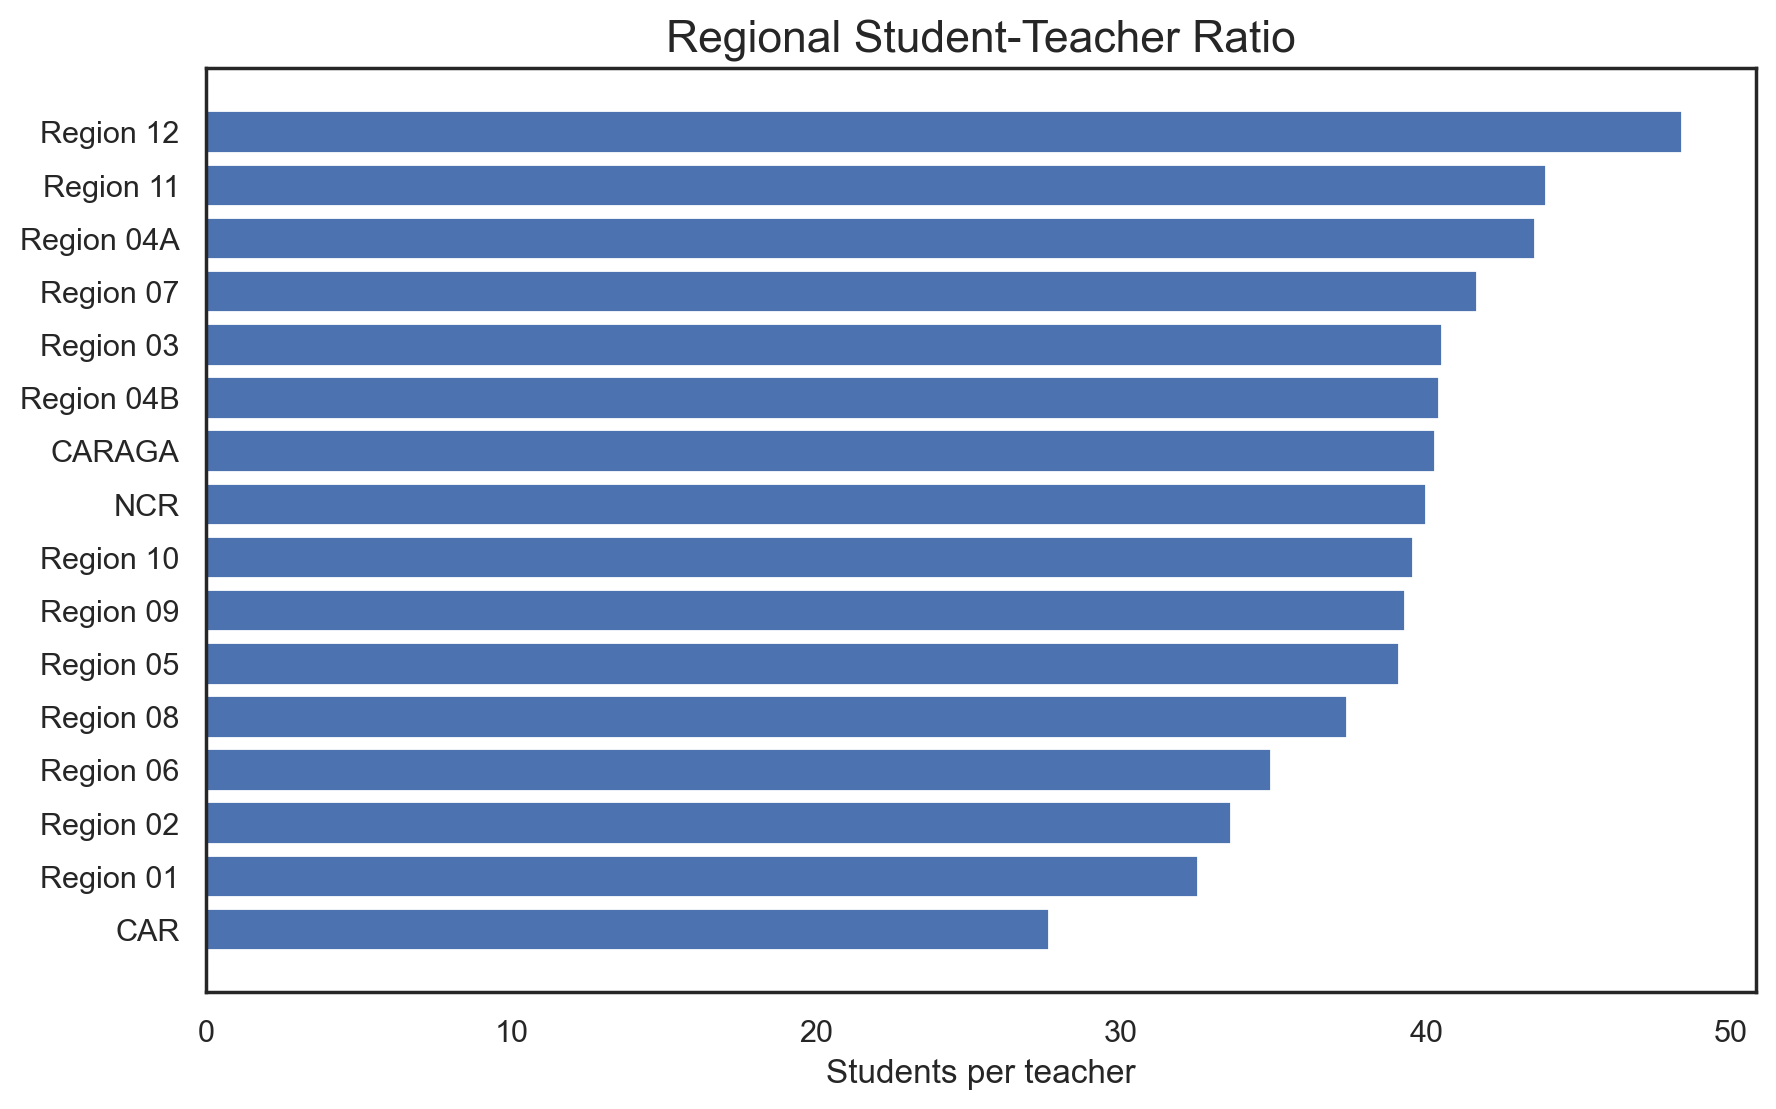

In [24]:
#plot of regional Student-Teacher Ratio
spt = region["Student_Teacher_Ratio"].sort_values()

# indicates if plotting on the figures or on subplots
plt.figure(figsize=(10,6), dpi=200) 

# the main code to create the graph
plt.barh(spt.index, spt.values) 
#plt.set_cmap("twilight")
# additional elements that can be customzed
plt.title("Regional Student-Teacher Ratio", fontsize = 16)
plt.xlabel("Students per teacher", fontsize=12)
#plt.xticks(range(0,250000000,25000000))

# display graph
plt.show()

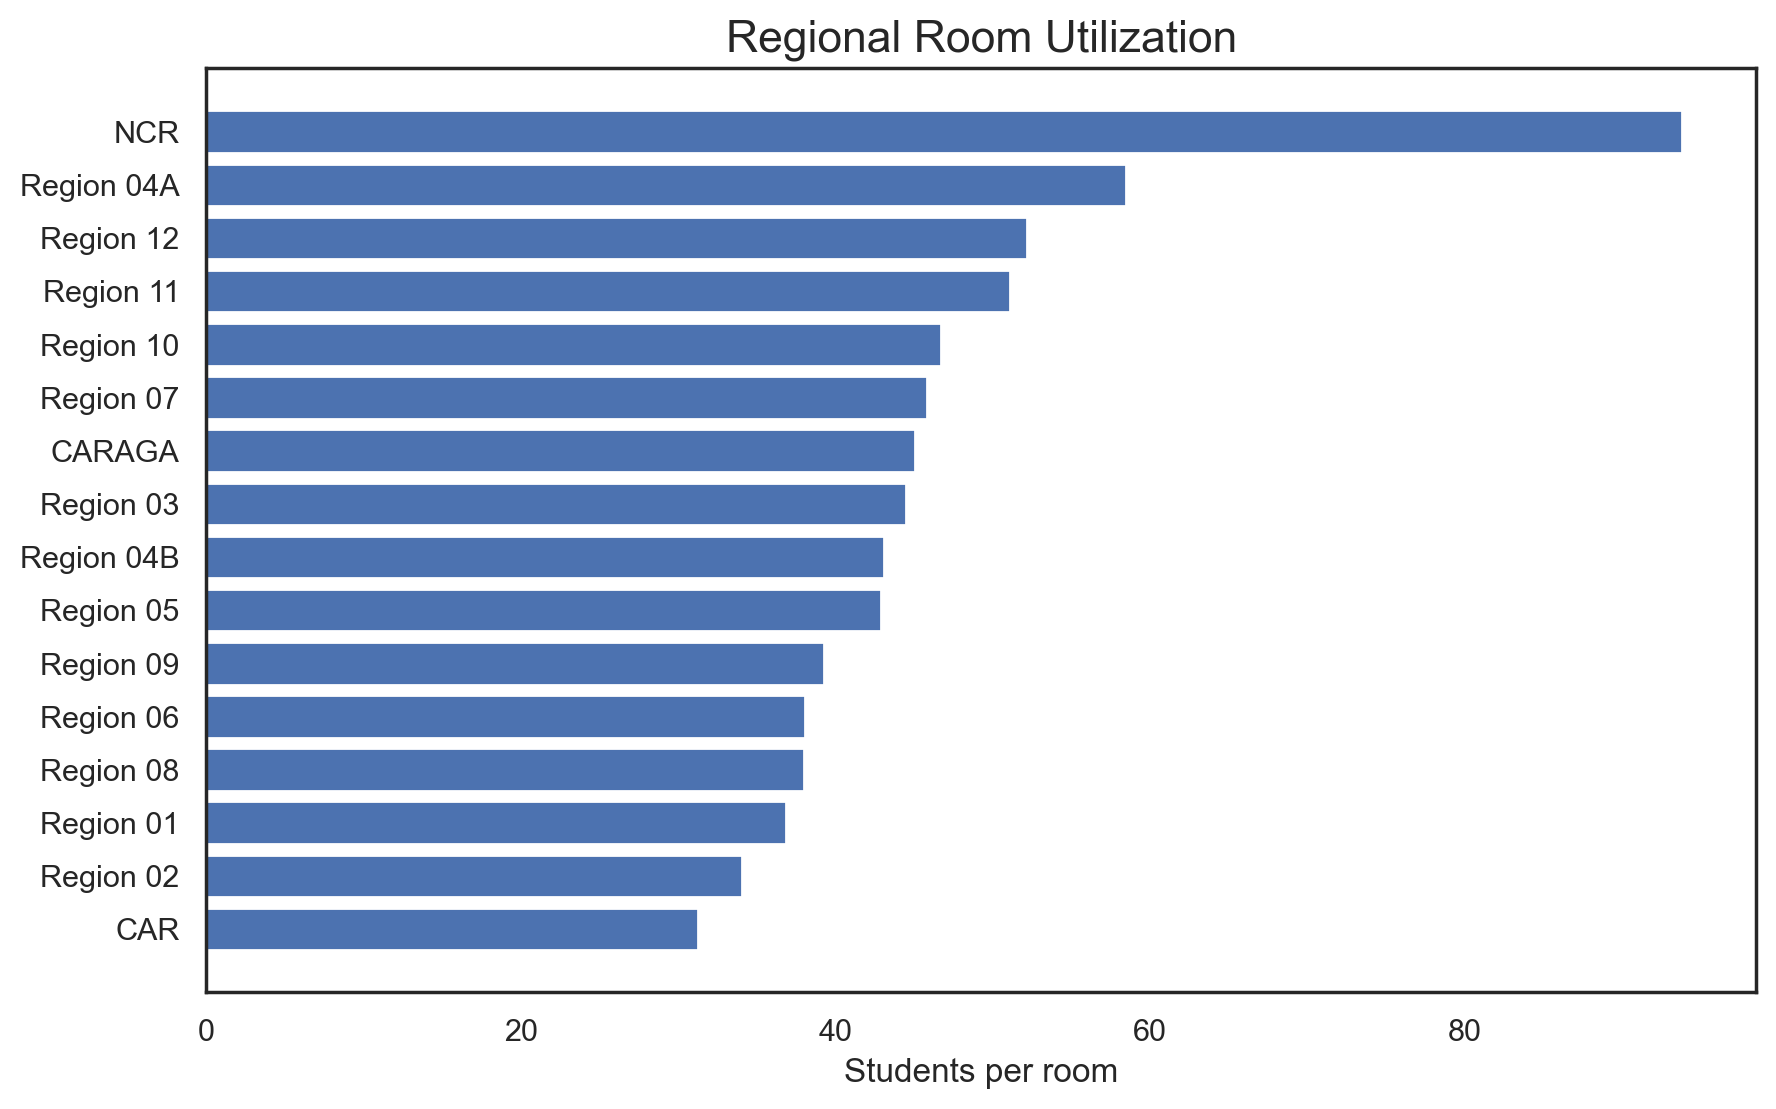

In [25]:
#plot of regional Student-Teacher Ratio
spr = region["Room_Utilization"].sort_values()

# indicates if plotting on the figures or on subplots
plt.figure(figsize=(10,6), dpi=200) 

# the main code to create the graph
plt.barh(spr.index, spr.values) 
#plt.set_cmap("twilight")
# additional elements that can be customzed
plt.title("Regional Room Utilization", fontsize = 16)
plt.xlabel("Students per room", fontsize=12)
#plt.xticks(range(0,250000000,25000000))

# display graph
plt.show()

In [26]:
region.corr()

,MOOE_Diff,Schools_Income,Urbanization,Schools_Enrollment,Schools_Rooms,Schools_Teachers,Student_Teacher_Ratio,Room_Utilization
MOOE_Diff,1.000000,0.789212,0.540542,0.975137,0.837074,0.964588,0.287682,0.386431
Schools_Income,0.789212,1.000000,0.181248,0.858233,0.883579,0.879233,0.307566,0.073246
Urbanization,0.540542,0.181248,1.000000,0.409966,0.080543,0.391908,0.257074,0.921243
Schools_Enrollment,0.975137,0.858233,0.409966,1.000000,0.887211,0.977397,0.370237,0.297492
Schools_Rooms,0.837074,0.883579,0.080543,0.887211,1.000000,0.937344,0.142018,-0.109197
Schools_Teachers,0.964588,0.879233,0.391908,0.977397,0.937344,1.000000,0.228624,0.217154
Student_Teacher_Ratio,0.287682,0.307566,0.257074,0.370237,0.142018,0.228624,1.000000,0.478660
Room_Utilization,0.386431,0.073246,0.921243,0.297492,-0.109197,0.217154,0.478660,1.000000


In [27]:
merged_data = pd.merge(shapefile, mpr, left_on="REGION", right_on="school.region", how="outer")
merged_data

,REGION,geometry,MOOE_Diff
0,ARMM,"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4...",NaN
1,Region 05,"MULTIPOLYGON (((122.98417 11.71056, 122.98333 ...",129156000.0
2,Region 04A,"MULTIPOLYGON (((125.22166 10.43444, 125.22195 ...",226992800.0
3,Region 02,"MULTIPOLYGON (((122.47040 16.91995, 122.47040 ...",70475800.0
4,CARAGA,"MULTIPOLYGON (((126.41750 7.96417, 126.41778 7...",50327800.0
5,Region 03,"MULTIPOLYGON (((120.62363 14.36788, 120.62368 ...",202060800.0
6,Region 07,"MULTIPOLYGON (((123.27111 9.08476, 123.27173 9...",123722400.0
7,CAR,"POLYGON ((121.37679 17.95473, 121.36825 17.939...",30126600.0
8,Region 11,"MULTIPOLYGON (((125.39778 5.43583, 125.39778 5...",72787000.0
9,Region 08,"MULTIPOLYGON (((125.07361 9.89472, 125.07333 9...",103283400.0


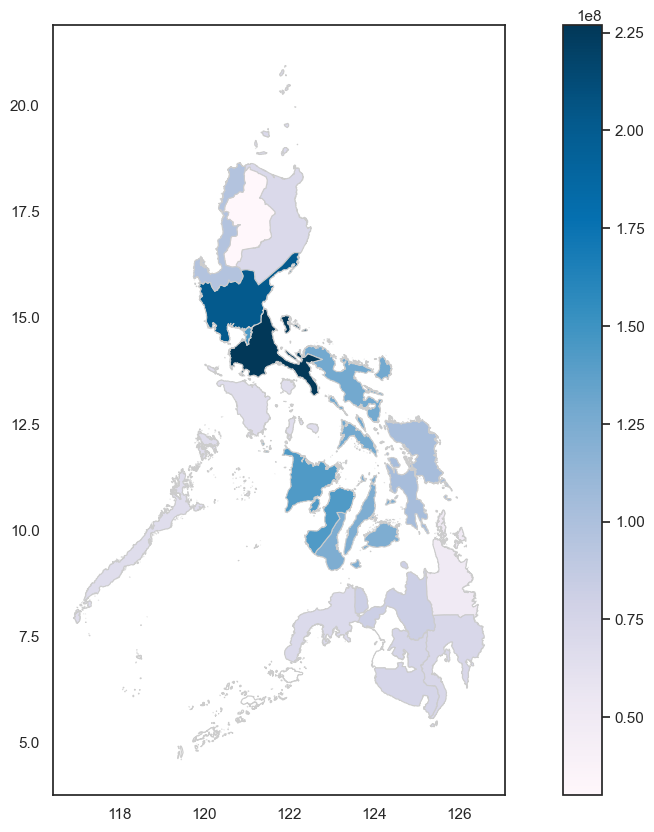

In [28]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'MOOE_Diff'
# set the range for the choropleth
vmin, vmax = merged_data['MOOE_Diff'].min(), merged_data['MOOE_Diff'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_data.plot(column=variable, cmap='PuBu', linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)

sm = plt.cm.ScalarMappable(cmap='PuBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

In [29]:
"""nep["total_budget"] = nep["PS"] + nep["MOOE"] + nep["FinEx"] + nep["CO"]
nep_melt = pd.melt(nep,id_vars="Year")

plt.figure(figsize=(15, 8))
sns.lineplot(x=r"Year", y="value", hue="variable", data=nep_melt)
plt.show()"""

'nep["total_budget"] = nep["PS"] + nep["MOOE"] + nep["FinEx"] + nep["CO"]\nnep_melt = pd.melt(nep,id_vars="Year")\n\nplt.figure(figsize=(15, 8))\nsns.lineplot(x=r"Year", y="value", hue="variable", data=nep_melt)\nplt.show()'